In [ ]:
!mkdir -p /content/data
!wget -O /content/data/monet2photo.zip https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/monet2photo.zip
!unzip /content/data/monet2photo.zip -d /content/data/


In [2]:
import glob
import random
import os
import tqdm
import numpy as np
import torch
from torch import nn, Tensor
from torchvision.utils import save_image, make_grid

device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_name = "monet2photo"

In [3]:
device

'cuda'

In [4]:
os.makedirs("images", exist_ok=True)

# 1. Dataset

In [5]:
import torchvision
from torch.utils.data import Dataset
from PIL import Image

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms=None, unaligned=False, split="train"):
        self.transform = torchvision.transforms.Compose(transforms)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, f"{split}A") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, f"{split}B") + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # grayscale to rgb
        if image_A.mode != "RGB":
            image_A = self.to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = self.to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


    def _to_rgb(self, image):
        rgb_image = Image.new("RGB", image.size)
        rgb_image.paste(image)
        return rgb_image

In [7]:
img_height = 256
img_width = 256

transforms = [
    torchvision.transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    torchvision.transforms.RandomCrop((img_height, img_width)),
    # torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]


train_set = ImageDataset(f"data/{dataset_name}", transforms=transforms, unaligned=True, split="train")
test_set = ImageDataset(f"data/{dataset_name}", transforms=transforms, unaligned=True, split="test")

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Model

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super().__init__()

        channels = input_shape[0]
        out_features = 64

        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]

        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)



class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        channels, height, width = input_shape

        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_features, out_features, normalize=True):
            layers = [nn.Conv2d(in_features, out_features, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_features))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, img):
        return self.model(img)

In [10]:
input_shape = (3, img_height, img_width)
n_residual_blocks = 3

G_AB = Generator(input_shape, n_residual_blocks).to(device)
G_BA = Generator(input_shape, n_residual_blocks).to(device)
D_A = Discriminator(input_shape).to(device)
D_B = Discriminator(input_shape).to(device)

# 3. Training

In [16]:
class ReplayBuffer:
    def __init__(self, max_size=50):
       assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful"
       self.max_size = max_size
       self.data = []

    def push_and_pop(self, data):
       to_return = []
       for element in data.data:
           element = torch.unsqueeze(element, 0)
           if len(self.data) < self.max_size:
              self.data.append(element)
              to_return.append(element)
           else:
              if random.uniform(0, 1) > 0.5:
                 i = random.randint(0, self.max_size-1)
                 to_return.append(self.data[i].clone())
                 self.data[i] = element
              else:
                 to_return.append(element)

       return torch.cat(to_return)


def sample_images(batches_done):
   '''Saves a generated sample from the validation set'''
   G_AB.eval()
   G_BA.eval()
   imgs = next(iter(val_loader))
   real_A = imgs['B'][:5, ...].to(device)
   fake_B = G_AB(real_A)
   real_B = imgs['A'][:5,...].to(device)
   fake_A = G_BA(real_B)

   real_A = make_grid(real_A, nrow=5, normalize=True)
   real_B = make_grid(real_B, nrow=5, normalize=True)
   fake_A = make_grid(fake_A, nrow=5, normalize=True)
   fake_B = make_grid(fake_B, nrow=5, normalize=True)
   image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
   save_image(image_grid, f'images/{batches_done}.png', normalize=True)


In [12]:
import itertools

LR = 0.0002

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()),
    lr=LR, betas=(0.5, 0.999)
)

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=LR, betas=(0.5, 0.999))

In [13]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [ ]:
EPOCHS = 50
save_interval = 10
lambda_cyc = 10
lambda_id = 5

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

hist = {
        "train_G_loss": [],
        "train_D_loss": [],
}
for epoch in range(EPOCHS):
    running_G_loss = 0.0
    running_D_loss = 0.0

    for batch in tqdm.tqdm(train_loader, total=len(train_loader)):

        real_imgs_A = batch["B"].to(device)
        real_imgs_B = batch["A"].to(device)

        valid = torch.ones((real_imgs_A.size(0), *D_A.output_shape)).to(device)
        fake = torch.zeros((real_imgs_A.size(0), *D_A.output_shape)).to(device)

        # --- Train Generator ---
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_imgs_A), real_imgs_A)
        loss_id_B = criterion_identity(G_AB(real_imgs_B), real_imgs_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_imgs_B = G_AB(real_imgs_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_imgs_B), valid)
        fake_imgs_A = G_BA(real_imgs_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_imgs_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recovered_imgs_A = G_BA(fake_imgs_B)
        loss_cycle_A = criterion_cycle(recovered_imgs_A, real_imgs_A)
        recovered_imgs_B = G_AB(fake_imgs_A)
        loss_cycle_B = criterion_cycle(recovered_imgs_B, real_imgs_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + loss_cycle*lambda_cyc + loss_identity*lambda_id
        running_G_loss += loss_G.item()
        loss_G.backward()
        optimizer_G.step()


        # --- Train Discriminator A ---
        optimizer_D_A.zero_grad()

        loss_real = criterion_GAN(D_A(real_imgs_A), valid)

        fake_A_ = fake_A_buffer.push_and_pop(fake_imgs_A)
        loss_fake = criterion_GAN(D_A(fake_A_), fake)

        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()

        # --- Train Discriminator B ---
        optimizer_D_B.zero_grad()

        loss_real = criterion_GAN(D_B(real_imgs_B), valid)

        fake_B_ = fake_B_buffer.push_and_pop(fake_imgs_B)
        loss_fake = criterion_GAN(D_B(fake_B_), fake)

        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()

        # Total loss
        loss_D = (loss_D_A + loss_D_B) / 2
        running_D_loss += loss_D.item()

    epoch_G_loss = running_G_loss / len(train_loader)
    epoch_D_loss = running_D_loss / len(train_loader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}")

    hist["train_G_loss"].append(epoch_G_loss)
    hist["train_D_loss"].append(epoch_D_loss)




In [17]:
    if epoch % save_interval == 0:
        sample_images(epoch)

(-0.5, 1291.5, 1039.5, -0.5)

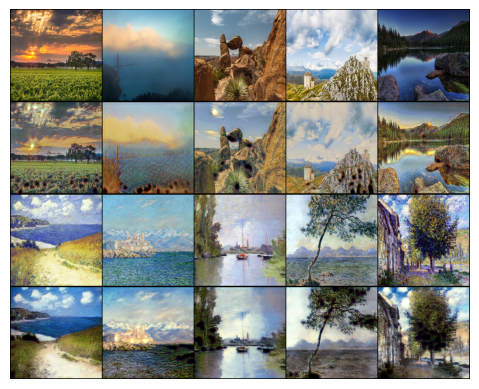

In [18]:
import matplotlib.pyplot as plt

img_path = './images/0.png'
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')